# Crawling data PTA

Python libraries:

*   BeautifulSoup: Used for web scraping and parsing HTML content.
*   requests: Used to send HTTP requests and retrieve web pages.
*   json: Used for working with JSON data.
*   pandas: Used for data manipulation and creating DataFrames.

How to work:

*   Collects information from a website PTA Trunojoyo.
*   It sends an HTTP request to the provided URL and parses the HTML content using BeautifulSoup.
*   It extracts information about journals, including the title, author, supervisors, URL, and abstract.
*   The information for each journal is stored in a dictionary, and all dictionaries are collected in a list called result.


In [ ]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd

def crawl_pta(url):
    result = []
    req = requests.get(url)
    soup = BeautifulSoup(req.text, "lxml")

    #find journal item
    journal_links = soup.find_all("li",{'data-id':'id-1'})

    #looping through journal item
    for idx,journal in enumerate(journal_links):
        journal_dict = {}

        #find journal title
        title_journal = journal.find('a',{'class':'title'}).text

        #find journal info
        info_journal = journal.find_all('span')
        writer_journal = info_journal[0].text.split(':')[1]
        supervisor1_journal = info_journal[1].text.split(':')[1]
        supervisor2_journal = info_journal[2].text.split(':')[1]

        #find journal link
        url_journal = journal.find('a',{'class':'gray button'}).get('href')

        #find journal content in url
        req_journal = requests.get(url_journal)
        soup_journal = BeautifulSoup(req_journal.text, "lxml")

        #find journal abstract
        abstract_journal = soup_journal.find("p",{'align':'justify'}).text

        #wrap in dictionary
        journal_dict['judul'] = title_journal
        journal_dict['penulis'] = writer_journal
        journal_dict['pembimbing_1'] = supervisor1_journal
        journal_dict['pembimbing_2'] = supervisor2_journal
        journal_dict['url'] = url_journal
        journal_dict['abstrak'] = abstract_journal
        result.append(journal_dict)

    return result

# crawl all data
data = []
for i in range (1,173):
  result = crawl_pta('https://pta.trunojoyo.ac.id/c_search/byprod/10/%d'%i)
  data += result

# get all abstrack from data
abstrak_list = []
for dictionary in data:
    if 'Abstrak' in dictionary:
        abstrak_list.append(dictionary['abstrak'])

# saving the dataframe
df = pd.DataFrame(data)
df.to_csv('crawl_result.csv',index=False)

# Text Normalization

Python libraries:

*   string: It provides a set of punctuation characters.
*   nltk: Natural Language Toolkit, used for text processing and analysis.
*   re: Regular expressions library for text pattern matching.
*   pandas: Used for data manipulation and working with tabular data in DataFrames.

How to work:

*   Tokenization: It breaks down the text into individual words or tokens.
*   Stopwords and Punctuation Removal: Common words (stopwords) and punctuation marks are removed from the text.
*   Numeric Word Removal: Words containing digits (numbers) are also removed.
*   The cleaned words are joined together to form a cleaned text.


## Steam

In [ ]:
!pip install Sastrawi

In [ ]:
import string
import nltk
import re
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')

data = pd.read_csv('crawl_result.csv')
data_cleaned = data.dropna(subset=[data.columns[-1]])
abstrak_list = data_cleaned.iloc[:, -1].tolist()

def text_normalization(text):
    # tokenization
    morph = nltk.word_tokenize(text.lower())

    # stopword n punctuations
    from nltk.corpus import stopwords
    stop = set(stopwords.words('indonesian') + list(string.punctuation))

    # steeming
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    Fact = StemmerFactory()
    Stemmer = Fact.create_stemmer()
    words = [Stemmer.stem(x) for x in morph if x not in stop]

    # delete word included num
    words = [word for word in words if not re.match(r'.*\d.*', word)]

    return " ".join(words)

# cleaning abstrack
result = []
for text in abstrak_list:
    clear_text = text_normalization(text)
    result.append(clear_text)

# append clean abstrack to last dataframe
data_cleaned['clean_abstrak'] = result

# saving the dataframe
data_cleaned.to_csv('clean_crawl_result.csv',index=False)

## Unsteam

In [ ]:
import string
import nltk
import re
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')

data = pd.read_csv('crawl_result.csv')
data_cleaned = data.dropna(subset=[data.columns[-1]])
abstrak_list = data_cleaned.iloc[:, -1].tolist()

def text_normalization(text):
    # tokenization
    morph = nltk.word_tokenize(text.lower())

    # stopword n punctuations
    from nltk.corpus import stopwords
    stop = set(stopwords.words('indonesian') + list(string.punctuation))
    words = [x for x in morph if x not in stop]

    # delete word included num
    words = [word for word in words if not re.match(r'.*\d.*', word)]

    return " ".join(words)

# cleaning abstrack
result = []
for text in abstrak_list:
    clear_text = text_normalization(text)
    result.append(clear_text)

# append clean abstrack to last dataframe
data_cleaned['clean_abstrak'] = result

# saving the dataframe
data_cleaned.to_csv('clean_crawl_result.csv',index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-25-1ef9f39d0179>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['clean_abstrak'] = result


# Word Frequency

Python libraries:

*   string: It provides a set of punctuation characters.
*   nltk: Natural Language Toolkit, used for text processing and analysis.
*   pandas: Used for data manipulation and working with tabular data in DataFrames.

How to work:

*   Tokenization: It breaks down the text into individual words or tokens.
*   Counting Word Frequency: It counts how many times each word appears in the text and stores the word frequencies in a dictionary.
*   Processes each cleaned abstract and calculates the word frequency for each one, creating a dictionary for each abstract.


In [ ]:
import string
import nltk
import pandas as pd
nltk.download('punkt')

data = pd.read_csv('clean_crawl_result.csv')
data_cleaned = data.dropna(subset=[data.columns[-1]])
abstrak_list = data_cleaned.iloc[:, -1].tolist()

def word_freq(text):
    # tokenization
    words = nltk.word_tokenize(text)

    # count freq
    word_count = {}
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        elif word in word_count:
            word_count[word] += 1

    return word_count

result = []
for text in abstrak_list:
    document = word_freq(text)
    result.append(document)

df = pd.DataFrame(result)
df.fillna(0, inplace=True)
df = df.astype(int)

# saving the dataframe
df.to_csv('word_freq.csv',index=False)
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sistem,informasi,akademik,siakad,berfungsi,menangani,pengelolaan,penyajian,data-data,fakultas,...,accelerated,segment,augmentasi,weak,stump,ransel,diseimbangkan,detector,anchor,pretrained
0,7,3,3,4,1,1,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
819,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0


# Word2Vec

In [ ]:
import string
import nltk
import pandas as pd
from gensim.models import Word2Vec
nltk.download('punkt')

data = pd.read_csv('clean_crawl_result.csv')
data_cleaned = data.dropna(subset=[data.columns[-1]])
abstrak_list = data_cleaned.iloc[:, -1].tolist()

# tokenization
sentences = [sentence.split() for sentence in abstrak_list]

# modeling
model = Word2Vec(sentences, vector_size=3, window=5, min_count=1, sg=0)

# try to get vector "trunojoyo":
vector_teknik = model.wv["trunojoyo"]
print(vector_teknik)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[-2.0853379  0.8942504  2.1501827]


# TF-IDF


In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import string
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

def custom_tokenizer(text):
    # tokenize
    tokens = nltk.word_tokenize(text)
    # remove word include num
    tokens = [token for token in tokens if not re.match(r'.*\d.*', token)]
    return tokens

def calculate_tfidf(documents):
    documents = [document.lower() for document in documents]
    # init object TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        stop_words=stopwords.words('indonesian'),
        tokenizer=custom_tokenizer,
        preprocessor=lambda text: text.translate(str.maketrans('', '', string.punctuation)),
    )

    # count TF-IDF
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # get all keys (terms)
    terms = tfidf_vectorizer.get_feature_names_out()

    # get matriks TF-IDF
    tfidf_values = tfidf_matrix.toarray()

    # count each terms in document without stopword and punctuation
    stop = set(stopwords.words('indonesian') + list(string.punctuation))
    word_counts = [Counter(word for word in nltk.word_tokenize(doc) if word not in stop) for doc in documents]

    return terms, tfidf_values, word_counts

terms, tfidf_values, word_counts = calculate_tfidf(abstrak_list)
pd.DataFrame(tfidf_values, columns=terms)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['berkalikali', 'bermacammacam', 'bersamasama', 'bersiapsiap', 'bertanyatanya', 'berturutturut', 'ingatingat', 'kirakira', 'masingmasing', 'menantinanti', 'pertamatama', 'samasama', 'sampaisampai', 'sebaikbaiknya', 'sekalikali', 'sekurangkurangnya', 'selamalamanya', 'sematamata', 'seolaholah', 'setidaktidaknya', 'teringatingat', 'tibatiba'] not in stop_words.
  warnings.warn(


,a,aalysis,aam,abad,abadi,ability,abjad,absensi,absolut,absolute,...,âstaff,âteknik,âtidak,âtincaâ,âuml,âwisata,âzâ,â,âµ,â¼
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Topic Modelling with LDA

In [ ]:
import string
import nltk
import pandas as pd
import gensim
from gensim import corpora, models
from collections import OrderedDict

data = pd.read_csv('clean_crawl_result.csv')
data_cleaned = data.dropna(subset=[data.columns[-1]])
abstrak_list = data_cleaned.iloc[:, -1].tolist()

# tokenization
texts = [sentence.split() for sentence in abstrak_list]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

total_topics = 3
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

data_lda = {i: OrderedDict(lda.show_topic(i,len(dictionary))) for i in range(total_topics)}

df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda.to_csv('probability_word_topic.csv',index=False)
df_lda

,metode,sistem,hasil,data,penelitian,citra,nilai,proses,akurasi,game,...,tool-tool,velocity,end-to-end,menyuruh,diperuntukan,lupa,mengisikan,persentasi,tidak/lupa,bersistem
0,0.019863,0.014665,0.014654,0.011686,0.01141,0.010705,0.009674,0.008545,0.006123,0.005997,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009
1,0.012390,0.017606,0.013113,0.014378,0.00786,0.004528,0.010249,0.009772,0.005965,0.001132,...,0.000043,0.000042,0.000027,0.000017,0.000019,0.000015,0.000015,0.000016,0.000015,0.000016
2,0.011669,0.020223,0.009441,0.009212,0.00840,0.007751,0.005939,0.007845,0.004141,0.005419,...,0.000017,0.000018,0.000035,0.000046,0.000044,0.000048,0.000048,0.000047,0.000048,0.000048


# Word Cloud

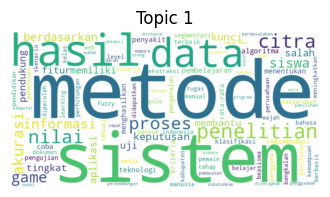

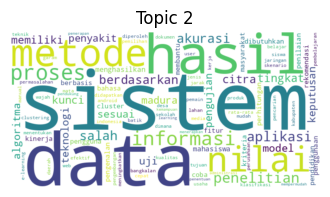

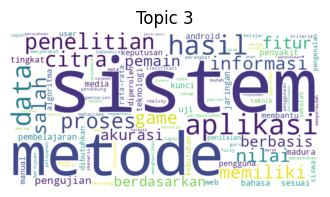

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def create_wordclouds(lda_model, num_topics, dictionary):
    for topic_id in range(num_topics):
        words = lda_model.show_topic(topic_id, topn=100)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))

        # plot the word cloud for the current topic
        plt.figure(figsize=(4, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id + 1}')
        plt.axis('off')
        plt.show()

create_wordclouds(lda, total_topics, dictionary)

# Topic Proportion

In [ ]:
topic_proportions = []
top_topic = []

for doc_topics in corpus_lda:
    # extract topic proportions for the document
    doc_topic_props = [prop for _, prop in doc_topics]

    # find the index of the topic with the highest proportion
    max_topic_index = doc_topic_props.index(max(doc_topic_props))

    # append the topic proportions to the list
    topic_proportions.append(doc_topic_props)

    # append the index of the top topic
    top_topic.append(max_topic_index)

document_titles = data_cleaned['judul'].tolist()
df_topic_proportions = pd.DataFrame({'judul': document_titles})

# add columns for each topic proportion
for i in range(total_topics):
    df_topic_proportions[f'topic_{i+1}'] = [props[i] for props in topic_proportions]

df_topic_proportions['top_topic'] = top_topic
df_topic_proportions.to_csv('document_topic_proportions.csv', index=False)
df_topic_proportions

,judul,topic_1,topic_2,topic_3,top_topic
0,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE \...,0.052555,0.054931,0.892514,2
1,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,0.068825,0.861011,0.070164,1
2,RANCANG BANGUN APLIKASI PROXY SERVER UNTUK\r\n...,0.059487,0.535554,0.404960,1
3,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,0.064406,0.064734,0.870860,2
4,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,0.056282,0.053652,0.890066,2
...,...,...,...,...,...
818,PENERAPAN ALGORITMA LONG-SHORT TERM MEMORY UNT...,0.896504,0.053565,0.049931,0
819,SISTEM PENCARIAN TEKS AL-QURAN TERJEMAHAN BERB...,0.056081,0.884085,0.059834,1
820,KLASIFIKASI KOMPLEKSITAS VISUAL CITRA SAMPAH M...,0.227774,0.050043,0.722183,2
821,IDENTIFIKASI BINER ATRIBUT PEJALAN KAKI MENGGU...,0.180652,0.060080,0.759268,2


# Clustering

In [ ]:
from sklearn.cluster import KMeans

df = df_topic_proportions.drop(columns=[df_topic_proportions.columns[0], df_topic_proportions.columns[-1]])
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels = kmeans.fit_predict(df)

df_topic_proportions['cluster'] = cluster_labels
df_topic_proportions

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,judul,topic_1,topic_2,topic_3,top_topic,cluster
0,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE \...,0.052555,0.054931,0.892514,2,2
1,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,0.068825,0.861011,0.070164,1,0
2,RANCANG BANGUN APLIKASI PROXY SERVER UNTUK\r\n...,0.059487,0.535554,0.404960,1,0
3,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,0.064406,0.064734,0.870860,2,2
4,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,0.056282,0.053652,0.890066,2,2
...,...,...,...,...,...,...
818,PENERAPAN ALGORITMA LONG-SHORT TERM MEMORY UNT...,0.896504,0.053565,0.049931,0,1
819,SISTEM PENCARIAN TEKS AL-QURAN TERJEMAHAN BERB...,0.056081,0.884085,0.059834,1,0
820,KLASIFIKASI KOMPLEKSITAS VISUAL CITRA SAMPAH M...,0.227774,0.050043,0.722183,2,2
821,IDENTIFIKASI BINER ATRIBUT PEJALAN KAKI MENGGU...,0.180652,0.060080,0.759268,2,2


# Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df, cluster_labels)
silhouette_avg

0.9107713088281926

# Crawl News

In [ ]:
from bs4 import BeautifulSoup
import requests

url = 'https://www.kompas.com/global/read/2023/10/31/055130270/pm-israel-tolak-gencatan-senjata-di-gaza-bersumpah-terus-bertempur-sampai'
req = requests.get(url)

soup = BeautifulSoup(req.text, "lxml")
news_content = soup.find("div",{'class':'read__content'})
p = news_content.find_all('p')
content = ' '.join(item .text for item in p)
content

' TEL AVIV, KOMPAS.com - Perdana Menteri (PM) Israel Benjamin Netanyahu menolak gencatan senjata di Gaza. Dia mengatakan pada Senin (30/10/2023) bahwa gencatan senjata dalam perang Israel melawan Hamas tidak akan terjadi. Dalam sebuah pengarahan kepada media asing, Netanyahu menyampaikan, gencatan senjata sama saja dengan menyerah kepada Hamas. Baca juga: Tank-tank Israel Bergerak Menuju Kota Gaza, Tembaki Mobil di Jalanan "Seruan untuk gencatan senjata adalah seruan agar Israel menyerah kepada Hamas. Ini tidak akan terjadi," katanya, seraya bersumpah bahwa Israel akan "berjuang sampai pertempuran ini dimenangi". Sebagaimana diberitakan AFP, sekutu Israel, Amerika Serikat (AS), juga menolak gencatan senjata. "Kami tidak yakin bahwa gencatan senjata adalah jawaban yang tepat untuk saat ini," kata juru bicara Dewan Keamanan Nasional AS John Kirby. Namun, dia menganggap perlu adanya jeda pertempuran untuk memasukkan bantuan ke Gaza. Ketika pasukan Israel bertempur melawan pasukan Hamas di

# Sentence Extraction

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

def extract_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

sentences = extract_sentences(content)
sentences = [s for s in sentences if "Baca juga" not in s]
sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[' TEL AVIV, KOMPAS.com - Perdana Menteri (PM) Israel Benjamin Netanyahu menolak gencatan senjata di Gaza.',
 'Dia mengatakan pada Senin (30/10/2023) bahwa gencatan senjata dalam perang Israel melawan Hamas tidak akan terjadi.',
 'Dalam sebuah pengarahan kepada media asing, Netanyahu menyampaikan, gencatan senjata sama saja dengan menyerah kepada Hamas.',
 'Ini tidak akan terjadi," katanya, seraya bersumpah bahwa Israel akan "berjuang sampai pertempuran ini dimenangi".',
 'Sebagaimana diberitakan AFP, sekutu Israel, Amerika Serikat (AS), juga menolak gencatan senjata.',
 '"Kami tidak yakin bahwa gencatan senjata adalah jawaban yang tepat untuk saat ini," kata juru bicara Dewan Keamanan Nasional AS John Kirby.',
 'Namun, dia menganggap perlu adanya jeda pertempuran untuk memasukkan bantuan ke Gaza.',
 'Ketika pasukan Israel bertempur melawan pasukan Hamas di dalam wilayah Palestina yang sempit dan mengirimkan tank-tank ke pinggiran Kota Gaza, kekhawatiran akan meluasnya krisis kemanusia

# Preprocessing

In [ ]:
import string
import nltk
import re
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')

def text_normalization(text):
    # tokenization
    morph = nltk.word_tokenize(text.lower())

    # stopword n punctuations
    from nltk.corpus import stopwords
    stop = set(stopwords.words('indonesian') + list(string.punctuation))
    words = [x for x in morph if x not in stop]

    # delete word included num
    words = [word for word in words if not re.match(r'.*\d.*', word)]

    return " ".join(words)

# cleaning abstrack
clear_sentences = []
for text in sentences:
    clear_text = text_normalization(text)
    clear_sentences.append(clear_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# TF-IDF

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import pandas as pd

kalimat = sentences
kalimat = clear_sentences

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(kalimat)
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

,afp,al,aliran,amerika,as,asing,aviv,bantuan,benjamin,berjuang,...,seraya,serikat,sesuai,sistem,tank,tel,terbatas,truk,volumenya,wilayah
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.303329,0.000000,0.303329,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.303329,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.407186,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.442875,...,0.442875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.370488,0.000000,0.000000,0.370488,0.248889,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.370488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.238746,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317184,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.429358,0.000000,0.000000,0.000000,0.000000,0.214679
8,0.000000,0.000000,0.000000,0.000000,0.229208,0.000000,0.000000,0.229208,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.583276,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.174905,0.000000,0.000000,0.349810,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260358,0.222545,0.260358,0.000000


# Cosine Similarity

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_similarities_df = pd.DataFrame(cosine_similarities)

label = ["Kalimat " + str(i) for i in range(1, len(cosine_similarities) + 1)]
cosine_similarities_df = cosine_similarities_df.set_axis(label, axis=0)
cosine_similarities_df = cosine_similarities_df.set_axis(label, axis=1)

cosine_similarities_df


,Kalimat 1,Kalimat 2,Kalimat 3,Kalimat 4,Kalimat 5,Kalimat 6,Kalimat 7,Kalimat 8,Kalimat 9,Kalimat 10,Kalimat 11
Kalimat 1,1.000000,0.159582,0.181099,0.049412,0.206113,0.079301,0.043522,0.043741,0.031451,0.024000,0.023631
Kalimat 2,0.159582,1.000000,0.252517,0.077666,0.194915,0.124647,0.000000,0.170268,0.000000,0.000000,0.000000
Kalimat 3,0.181099,0.252517,1.000000,0.000000,0.110976,0.106454,0.000000,0.049396,0.000000,0.000000,0.000000
Kalimat 4,0.049412,0.077666,0.000000,1.000000,0.060352,0.000000,0.152775,0.034971,0.000000,0.000000,0.000000
Kalimat 5,0.206113,0.194915,0.110976,0.060352,1.000000,0.156281,0.000000,0.029255,0.057047,0.043532,0.000000
Kalimat 6,0.079301,0.124647,0.106454,0.000000,0.156281,1.000000,0.000000,0.000000,0.143315,0.041758,0.000000
Kalimat 7,0.043522,0.000000,0.000000,0.152775,0.000000,0.000000,1.000000,0.030803,0.121656,0.148311,0.091407
Kalimat 8,0.043741,0.170268,0.049396,0.034971,0.029255,0.000000,0.030803,1.000000,0.022259,0.016986,0.056934
Kalimat 9,0.031451,0.000000,0.000000,0.000000,0.057047,0.143315,0.121656,0.022259,1.000000,0.341972,0.066054
Kalimat 10,0.024000,0.000000,0.000000,0.000000,0.043532,0.041758,0.148311,0.016986,0.341972,1.000000,0.129291


# Graph

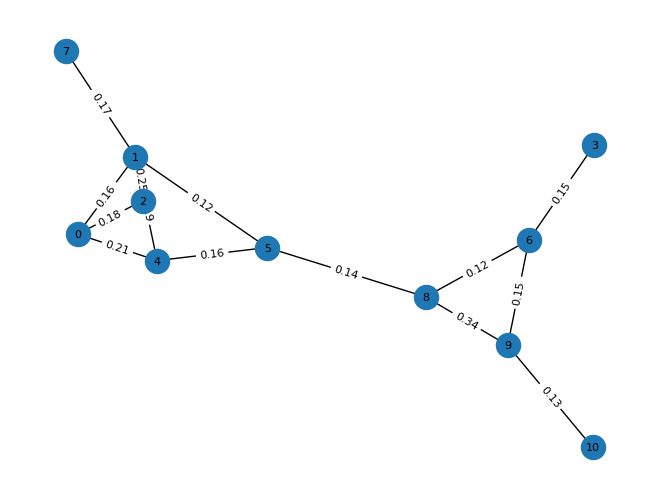

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graf = nx.Graph()
for i in range(len(kalimat)):
    for j in range(i + 1, len(kalimat)):
        similarity = cosine_similarities[i][j]
        if similarity > 0.12:
            graf.add_edge(i, j, weight=similarity)

# Add isolated nodes
isolated_nodes = list(set(range(len(kalimat))) - set(graf.nodes))
graf.add_nodes_from(isolated_nodes)

closeness_centrality = nx.closeness_centrality(graf)

pos = nx.spring_layout(graf)
nx.draw(graf, pos, with_labels=False)

# Use label node match with index
node_labels = {i: str(i) for i in graf.nodes}
nx.draw_networkx_labels(graf, pos, labels=node_labels, font_size=8)

# Show similarity on label edge
edge_labels = {edge: f'{graf[edge[0]][edge[1]]["weight"]:.2f}' for edge in graf.edges}
nx.draw_networkx_edge_labels(graf, pos, edge_labels=edge_labels, font_size=8)

plt.show()


# Closeness Centrality

In [ ]:
kalimat_penting_sorted = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)

for idx in kalimat_penting_sorted:
    print(f"Node {idx}: Closeness Centrality = {closeness_centrality[idx]:.4f}")

kalimat_penting = kalimat_penting_sorted[:3]
for idx in kalimat_penting:
    print(kalimat[idx])

Node 5: Closeness Centrality = 0.5263
Node 8: Closeness Centrality = 0.5000
Node 1: Closeness Centrality = 0.4762
Node 4: Closeness Centrality = 0.4348
Node 6: Closeness Centrality = 0.4000
Node 9: Closeness Centrality = 0.4000
Node 0: Closeness Centrality = 0.3571
Node 2: Closeness Centrality = 0.3448
Node 7: Closeness Centrality = 0.3333
Node 3: Closeness Centrality = 0.2941
Node 10: Closeness Centrality = 0.2941
`` gencatan senjata '' juru bicara dewan keamanan nasional as john kirby
kirby as meningkatkan truk bantuan gaza penyeberangan rafah mesir truk
senin gencatan senjata perang israel melawan hamas


# Page Rank

In [ ]:
pagerank = nx.pagerank(graf)

# sort PageRank
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# show sorted PageRank
for node, rank in sorted_pagerank:
    print(f"Node {node}: PageRank = {rank:.4f}")

for node, rank in sorted_pagerank[:3]:
    print(kalimat[node])

Node 1: PageRank = 0.1603
Node 9: PageRank = 0.1355
Node 8: PageRank = 0.1251
Node 6: PageRank = 0.1003
Node 4: PageRank = 0.0997
Node 0: PageRank = 0.0972
Node 5: PageRank = 0.0813
Node 2: PageRank = 0.0792
Node 3: PageRank = 0.0444
Node 7: PageRank = 0.0394
Node 10: PageRank = 0.0377
senin gencatan senjata perang israel melawan hamas
bantuan terbatas masuk gaza mesir kesepakatan ditengahi as volumenya ratusan truk lembaga-lembaga bantuan dibutuhkan
kirby as meningkatkan truk bantuan gaza penyeberangan rafah mesir truk


# Eigenvector Centrality

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(graf)

# sort Eigenvector Centrality
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# show sorted Eigenvector Centrality
for node, centrality in sorted_eigenvector_centrality:
    print(f"Node {node}: Eigenvector Centrality = {centrality:.4f}")

for node, centrality in sorted_eigenvector_centrality[:3]:
    print(kalimat[node])

Node 1: Eigenvector Centrality = 0.5525
Node 4: Eigenvector Centrality = 0.4334
Node 0: Eigenvector Centrality = 0.4173
Node 5: Eigenvector Centrality = 0.3781
Node 2: Eigenvector Centrality = 0.3119
Node 8: Eigenvector Centrality = 0.1898
Node 7: Eigenvector Centrality = 0.1777
Node 9: Eigenvector Centrality = 0.1062
Node 6: Eigenvector Centrality = 0.1062
Node 3: Eigenvector Centrality = 0.0341
Node 10: Eigenvector Centrality = 0.0341
senin gencatan senjata perang israel melawan hamas
diberitakan afp sekutu israel amerika serikat as menolak gencatan senjata
tel aviv kompas.com perdana menteri pm israel benjamin netanyahu menolak gencatan senjata gaza


# Text Rank

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Function to extract features (words) and create a table of word relationships
def extract_features_and_create_table(documents):
    # Initialize CountVectorizer to convert text to word count vectors
    vectorizer = CountVectorizer()

    # Fit and transform the documents
    word_matrix = vectorizer.fit_transform(documents)

    # Convert word matrix to a DataFrame
    words_df = pd.DataFrame(word_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Initialize an empty DataFrame for word relationships
    word_relationships = pd.DataFrame(index=vectorizer.get_feature_names_out(),
                                      columns=vectorizer.get_feature_names_out()).fillna(0)

    # Iterate over the DataFrame to fill the word relationships
    for word1 in word_relationships.index:
        for word2 in word_relationships.columns:
            # Check if both words appear together in any document
            if any(words_df[word1] & words_df[word2]):
                word_relationships.at[word1, word2] = 1

    return word_relationships

# Extract features and create the table
word_relationship_table = extract_features_and_create_table(kalimat)

# Display the table of word relationships
word_relationship_table.head()  # Displaying only the head for brevity

,afp,al,aliran,amerika,as,asing,aviv,bantuan,benjamin,berjuang,...,seraya,serikat,sesuai,sistem,tank,tel,terbatas,truk,volumenya,wilayah
afp,1,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
al,0,1,1,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
aliran,0,1,1,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
amerika,1,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
as,1,0,0,1,1,0,0,1,0,0,...,0,1,0,0,0,0,1,1,1,0


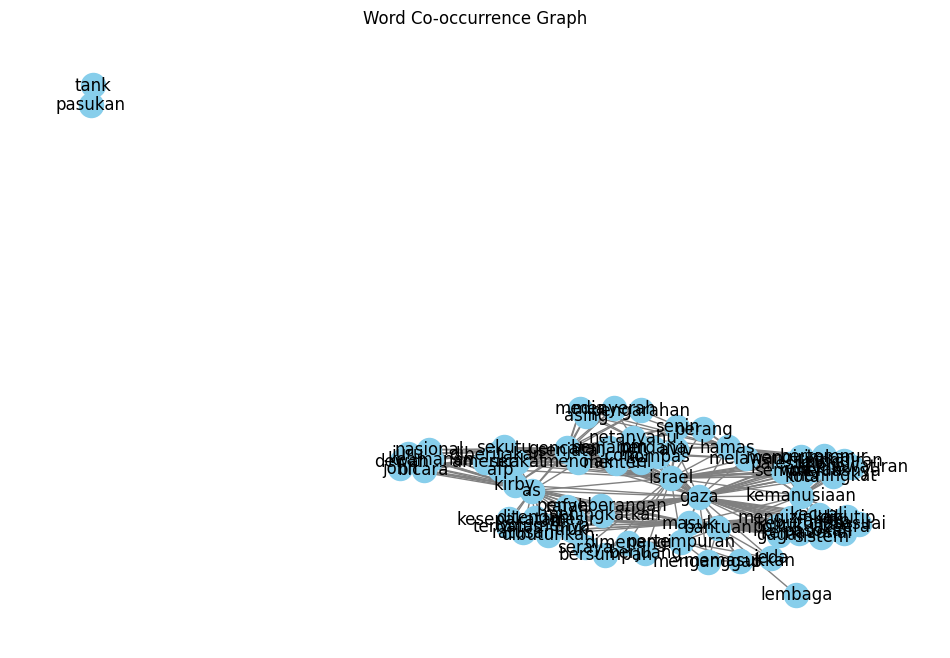

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the word relationship table
def create_graph_from_table(word_relationship_table):
    # Initialize an undirected graph
    G = nx.Graph()

    # Add nodes and edges to the graph
    for word1 in word_relationship_table.index:
        for word2 in word_relationship_table.columns:
            if word_relationship_table.at[word1, word2] == 1 and word1 != word2:
                G.add_edge(word1, word2)

    return G

# Create the graph
word_graph = create_graph_from_table(word_relationship_table)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(word_graph, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Word Co-occurrence Graph")
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
# To determine the most important words, we can use centrality measures from the graph.
# One common measure is degree centrality, which is the number of edges connected to a node.
# The assumption is that the more connections a word has, the more important it might be.

# Calculate degree centrality for each node in the graph
centrality = nx.degree_centrality(word_graph)

# Convert the centrality dictionary to a sorted list of tuples
sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)

# Get the top 3 most central words
top_3_words = sorted_centrality[:4]

top_3_words

[('gaza', 0.710843373493976),
 ('israel', 0.4819277108433735),
 ('gencatan', 0.4096385542168675),
 ('senjata', 0.4096385542168675)]

In [ ]:

!jupyter nbconvert --to html 'ppw_project.ipynb'

[NbConvertApp] Converting notebook ppw_project.ipynb to html
[NbConvertApp] Writing 1291055 bytes to ppw_project.html


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
